In [42]:
import torch
import clip
import time
import shutil
import math
import random

import numpy as np
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision.datasets as datasets

import torch.nn as nn
import torch.optim as optim
import torch.utils.data

In [43]:
torch.cuda.is_available()

True

In [44]:
start_epoch = 0
epochs = 200
batch_size = 32
lr = 30
print_frequency = 10

In [45]:
class MLP(nn.Module):
    def __init__(self, dim):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(dim, 128)
        self.out = nn.Linear(128, 2)
    
    def forward(self, x):
        x = x.to(torch.float32)
        x = F.relu(self.hidden1(x))
        x = self.out(x)
        return x

In [64]:
class myMoCo(nn.Module):
    def __init__(self):
        super(myMoCo, self).__init__()
        
        self.pos = 4 #the number of positive samples
        
        self.indim = 512
        self.outdim = 2
        self.m = 0.999
        self.T = 0.07
        self.K = 128*(self.pos-1)
        
        self.mlp_q = MLP(self.indim).cuda()
        self.mlp_k = MLP(self.indim).cuda()
        for param_q, param_k in zip(self.mlp_q.parameters(), self.mlp_k.parameters()):
            param_k.data.copy_(param_q.data) #initialize key MLP
            param_k.required_grad = False
        
        self.register_buffer("queue", torch.randn(self.outdim, self.K))
        self.queue = nn.functional.normalize(self.queue, dim=0)
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))   
        
    """
    input_q : Batch x feat_size == N x inDim
    input_k : (Batch x pos_pairs) x feat_size == (N x J) x inDim ==> M x inDim
    """ 
    def forward(self, pos_pairs):
        input_q = pos_pairs[:,:1,:] #N x 1  x inDim
        input_q = input_q.squeeze() #N x inDim
        input_q = nn.functional.normalize(input_q, dim=1)
        
        q = self.mlp_q(input_q) # N x outDim
        q = nn.functional.normalize(q, dim=1)
        
        with torch.no_grad():
            self._momentum_update_key_encoder()
            
            input_k = pos_pairs[:,1:,:] #N x J x inDim
            N = input_k.shape[0]
            J = input_k.shape[1]
            input_k = torch.reshape(input_k, (-1, self.indim)) # reshape : (N x J) x inDim ==> M x inDim
            input_k = nn.functional.normalize(input_k, dim=1)
            
            k = self.mlp_k(input_k) # M x outDim
            k = nn.functional.normalize(k, dim=1)
            
            k = torch.reshape(k, (N, -1, self.outdim)) # undo reshape : M x outDim ==>(N x J) x outDim
        
        loss_pos = torch.einsum("nc,njc->n", [q, k]).unsqueeze(-1) # N x 1
        loss_pos /= self.pos-1
        
        loss_neg = torch.einsum("nc,ck->nk", [q, self.queue.clone().detach()]) # N x K
        logits = torch.cat([loss_pos, loss_neg], dim=1) # N x (1+K)
        logits /= self.T
        
        labels = torch.zeros(logits.shape[0], dtype=torch.long).cuda()
        
        self._dequeue_and_enqueue(k)
        
        return logits, labels
    
    
    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        for param_q, param_k in zip(self.mlp_q.parameters(), self.mlp_k.parameters()):
            param_k.data = param_k.data*self.m + param_q.data*(1.0-self.m)
        
    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
#         chosen = random.randint(0, self.pos-2)
#         keys = keys[:, chosen, :].squeeze() #chose one view: N x J x C ==> N x 1 x C ==> N x C
        keys = torch.reshape(keys, (-1, self.outdim))
        M = keys.shape[0]
        ptr = int(self.queue_ptr)
        self.queue[:, ptr : ptr + M] = keys.T
        ptr = (ptr + M) % self.K
        self.queue_ptr[0] = ptr

In [65]:
def adjust_learning_rate(optimizer, epoch):
    lr = 1e-3
    lr *= 0.5 * (1.0 + math.cos(math.pi * epoch / epochs))
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [66]:
def save_checkpoint(state, is_best, filename):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, "model_best.pth.tar")

In [67]:
def train(train_loader, model, criterion, optimizer, epoch):
    for i, pos_pairs in enumerate(train_loader):
        
        output, target = model(pos_pairs)
        loss = criterion(output, target)
       
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print('Epoch[{0}]    Iter[{1}/8]    Loss: {2}'.format(epoch+1, i+1, loss))
        

In [68]:
def main():
    
    model = myMoCo().cuda()
    criterion = nn.CrossEntropyLoss().cuda()
    optimizer = optim.SGD(
        model.parameters(), 
        lr = 1e-3,
        momentum = 0.9,
        weight_decay = 1e-4
    )
    
    """
    # optionally resume from a checkpoint
    ...
    """
    
    cudnn.benchmark = True
    
    train_file = '../CUHK01/dataset.pkl'
    N = 256
    B = 32
    
    train_dataset = torch.load(train_file).cuda()
    train_dataset = train_dataset[:N]
    
    trainloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size = B,
        shuffle = True
    )
    
    for epoch in range(start_epoch, epochs):
        
        adjust_learning_rate(optimizer, epoch)
        train(trainloader, model, criterion, optimizer, epoch)
        
        print('\n\n')
        
        torch.save(model.mlp_q.state_dict(), './pretrained/MLP/mlp{:04d}.pth.tar'.format(epoch+1))
        save_checkpoint(
            {
                "epoch": epoch + 1,
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
            },
            is_best=False,
            filename="./pretrained/myMoCo/checkpoint_{:04d}.pth.tar".format(epoch+1),
        )

In [69]:
main()
print('DONE!')

Epoch[1]    Iter[1/8]    Loss: 3.777284860610962
Epoch[1]    Iter[2/8]    Loss: 5.222867965698242
Epoch[1]    Iter[3/8]    Loss: 5.721696853637695
Epoch[1]    Iter[4/8]    Loss: 5.928982257843018
Epoch[1]    Iter[5/8]    Loss: 5.970641613006592
Epoch[1]    Iter[6/8]    Loss: 5.948601245880127
Epoch[1]    Iter[7/8]    Loss: 5.983639240264893
Epoch[1]    Iter[8/8]    Loss: 5.949517726898193



Epoch[2]    Iter[1/8]    Loss: 5.952399253845215
Epoch[2]    Iter[2/8]    Loss: 5.956362724304199
Epoch[2]    Iter[3/8]    Loss: 5.943922996520996
Epoch[2]    Iter[4/8]    Loss: 5.946775436401367
Epoch[2]    Iter[5/8]    Loss: 5.969717502593994
Epoch[2]    Iter[6/8]    Loss: 5.957752227783203
Epoch[2]    Iter[7/8]    Loss: 5.9516072273254395
Epoch[2]    Iter[8/8]    Loss: 5.926485538482666



Epoch[3]    Iter[1/8]    Loss: 5.981459140777588
Epoch[3]    Iter[2/8]    Loss: 5.954057693481445
Epoch[3]    Iter[3/8]    Loss: 5.947371006011963
Epoch[3]    Iter[4/8]    Loss: 5.9655375480651855
Epoch[3]    

Epoch[25]    Iter[1/8]    Loss: 5.953950881958008
Epoch[25]    Iter[2/8]    Loss: 5.950544834136963
Epoch[25]    Iter[3/8]    Loss: 5.943033695220947
Epoch[25]    Iter[4/8]    Loss: 5.960649013519287
Epoch[25]    Iter[5/8]    Loss: 5.953338146209717
Epoch[25]    Iter[6/8]    Loss: 5.950127124786377
Epoch[25]    Iter[7/8]    Loss: 5.963711738586426
Epoch[25]    Iter[8/8]    Loss: 5.933159828186035



Epoch[26]    Iter[1/8]    Loss: 5.9544782638549805
Epoch[26]    Iter[2/8]    Loss: 5.936870098114014
Epoch[26]    Iter[3/8]    Loss: 5.9589972496032715
Epoch[26]    Iter[4/8]    Loss: 5.957029819488525
Epoch[26]    Iter[5/8]    Loss: 5.953390121459961
Epoch[26]    Iter[6/8]    Loss: 5.9534454345703125
Epoch[26]    Iter[7/8]    Loss: 5.953031063079834
Epoch[26]    Iter[8/8]    Loss: 5.950675010681152



Epoch[27]    Iter[1/8]    Loss: 5.956895351409912
Epoch[27]    Iter[2/8]    Loss: 5.952992916107178
Epoch[27]    Iter[3/8]    Loss: 5.943135738372803
Epoch[27]    Iter[4/8]    Loss: 5.9407863

Epoch[49]    Iter[1/8]    Loss: 5.948437690734863
Epoch[49]    Iter[2/8]    Loss: 5.954164505004883
Epoch[49]    Iter[3/8]    Loss: 5.939745903015137
Epoch[49]    Iter[4/8]    Loss: 5.927596092224121
Epoch[49]    Iter[5/8]    Loss: 5.950538158416748
Epoch[49]    Iter[6/8]    Loss: 5.947000503540039
Epoch[49]    Iter[7/8]    Loss: 5.950045108795166
Epoch[49]    Iter[8/8]    Loss: 5.957053184509277



Epoch[50]    Iter[1/8]    Loss: 5.950817584991455
Epoch[50]    Iter[2/8]    Loss: 5.942691802978516
Epoch[50]    Iter[3/8]    Loss: 5.938488483428955
Epoch[50]    Iter[4/8]    Loss: 5.941954612731934
Epoch[50]    Iter[5/8]    Loss: 5.942447185516357
Epoch[50]    Iter[6/8]    Loss: 5.974099636077881
Epoch[50]    Iter[7/8]    Loss: 5.939630031585693
Epoch[50]    Iter[8/8]    Loss: 5.955088138580322



Epoch[51]    Iter[1/8]    Loss: 5.956601619720459
Epoch[51]    Iter[2/8]    Loss: 5.933590888977051
Epoch[51]    Iter[3/8]    Loss: 5.939294815063477
Epoch[51]    Iter[4/8]    Loss: 5.9564614295

Epoch[72]    Iter[1/8]    Loss: 5.953064441680908
Epoch[72]    Iter[2/8]    Loss: 5.951503276824951
Epoch[72]    Iter[3/8]    Loss: 5.935093879699707
Epoch[72]    Iter[4/8]    Loss: 5.937602996826172
Epoch[72]    Iter[5/8]    Loss: 5.945241928100586
Epoch[72]    Iter[6/8]    Loss: 5.949632167816162
Epoch[72]    Iter[7/8]    Loss: 5.941051483154297
Epoch[72]    Iter[8/8]    Loss: 5.939154148101807



Epoch[73]    Iter[1/8]    Loss: 5.955932140350342
Epoch[73]    Iter[2/8]    Loss: 5.944364070892334
Epoch[73]    Iter[3/8]    Loss: 5.946325778961182
Epoch[73]    Iter[4/8]    Loss: 5.930893421173096
Epoch[73]    Iter[5/8]    Loss: 5.935590744018555
Epoch[73]    Iter[6/8]    Loss: 5.946317672729492
Epoch[73]    Iter[7/8]    Loss: 5.9333391189575195
Epoch[73]    Iter[8/8]    Loss: 5.9410929679870605



Epoch[74]    Iter[1/8]    Loss: 5.950859069824219
Epoch[74]    Iter[2/8]    Loss: 5.9501776695251465
Epoch[74]    Iter[3/8]    Loss: 5.95236349105835
Epoch[74]    Iter[4/8]    Loss: 5.94474124

Epoch[95]    Iter[7/8]    Loss: 5.944281101226807
Epoch[95]    Iter[8/8]    Loss: 5.9484100341796875



Epoch[96]    Iter[1/8]    Loss: 5.93004035949707
Epoch[96]    Iter[2/8]    Loss: 5.939234733581543
Epoch[96]    Iter[3/8]    Loss: 5.930286884307861
Epoch[96]    Iter[4/8]    Loss: 5.920368671417236
Epoch[96]    Iter[5/8]    Loss: 5.93794059753418
Epoch[96]    Iter[6/8]    Loss: 5.94660758972168
Epoch[96]    Iter[7/8]    Loss: 5.953853130340576
Epoch[96]    Iter[8/8]    Loss: 5.941853046417236



Epoch[97]    Iter[1/8]    Loss: 5.941629886627197
Epoch[97]    Iter[2/8]    Loss: 5.935377597808838
Epoch[97]    Iter[3/8]    Loss: 5.938872337341309
Epoch[97]    Iter[4/8]    Loss: 5.924653053283691
Epoch[97]    Iter[5/8]    Loss: 5.9346699714660645
Epoch[97]    Iter[6/8]    Loss: 5.944981575012207
Epoch[97]    Iter[7/8]    Loss: 5.94415807723999
Epoch[97]    Iter[8/8]    Loss: 5.9510273933410645



Epoch[98]    Iter[1/8]    Loss: 5.945673942565918
Epoch[98]    Iter[2/8]    Loss: 5.92628812

Epoch[119]    Iter[4/8]    Loss: 5.925244331359863
Epoch[119]    Iter[5/8]    Loss: 5.932672500610352
Epoch[119]    Iter[6/8]    Loss: 5.9364333152771
Epoch[119]    Iter[7/8]    Loss: 5.921945571899414
Epoch[119]    Iter[8/8]    Loss: 5.924441337585449



Epoch[120]    Iter[1/8]    Loss: 5.94089937210083
Epoch[120]    Iter[2/8]    Loss: 5.938778400421143
Epoch[120]    Iter[3/8]    Loss: 5.931064605712891
Epoch[120]    Iter[4/8]    Loss: 5.930751323699951
Epoch[120]    Iter[5/8]    Loss: 5.9207048416137695
Epoch[120]    Iter[6/8]    Loss: 5.933658123016357
Epoch[120]    Iter[7/8]    Loss: 5.924910068511963
Epoch[120]    Iter[8/8]    Loss: 5.923132419586182



Epoch[121]    Iter[1/8]    Loss: 5.928915977478027
Epoch[121]    Iter[2/8]    Loss: 5.943060398101807
Epoch[121]    Iter[3/8]    Loss: 5.9266791343688965
Epoch[121]    Iter[4/8]    Loss: 5.934845924377441
Epoch[121]    Iter[5/8]    Loss: 5.931097030639648
Epoch[121]    Iter[6/8]    Loss: 5.924646377563477
Epoch[121]    Iter[7/8]   

Epoch[142]    Iter[7/8]    Loss: 5.92020845413208
Epoch[142]    Iter[8/8]    Loss: 5.918332099914551



Epoch[143]    Iter[1/8]    Loss: 5.914766311645508
Epoch[143]    Iter[2/8]    Loss: 5.951513290405273
Epoch[143]    Iter[3/8]    Loss: 5.922235012054443
Epoch[143]    Iter[4/8]    Loss: 5.940061569213867
Epoch[143]    Iter[5/8]    Loss: 5.912796497344971
Epoch[143]    Iter[6/8]    Loss: 5.923604965209961
Epoch[143]    Iter[7/8]    Loss: 5.902493953704834
Epoch[143]    Iter[8/8]    Loss: 5.910752296447754



Epoch[144]    Iter[1/8]    Loss: 5.935431003570557
Epoch[144]    Iter[2/8]    Loss: 5.9403462409973145
Epoch[144]    Iter[3/8]    Loss: 5.921947479248047
Epoch[144]    Iter[4/8]    Loss: 5.909196853637695
Epoch[144]    Iter[5/8]    Loss: 5.934201240539551
Epoch[144]    Iter[6/8]    Loss: 5.9053874015808105
Epoch[144]    Iter[7/8]    Loss: 5.904537200927734
Epoch[144]    Iter[8/8]    Loss: 5.925022125244141



Epoch[145]    Iter[1/8]    Loss: 5.939350128173828
Epoch[145]    Iter[2/

Epoch[166]    Iter[2/8]    Loss: 5.941244125366211
Epoch[166]    Iter[3/8]    Loss: 5.905074596405029
Epoch[166]    Iter[4/8]    Loss: 5.906886577606201
Epoch[166]    Iter[5/8]    Loss: 5.921187877655029
Epoch[166]    Iter[6/8]    Loss: 5.912374973297119
Epoch[166]    Iter[7/8]    Loss: 5.939869403839111
Epoch[166]    Iter[8/8]    Loss: 5.912555694580078



Epoch[167]    Iter[1/8]    Loss: 5.920961856842041
Epoch[167]    Iter[2/8]    Loss: 5.90256929397583
Epoch[167]    Iter[3/8]    Loss: 5.924848556518555
Epoch[167]    Iter[4/8]    Loss: 5.904579162597656
Epoch[167]    Iter[5/8]    Loss: 5.919424533843994
Epoch[167]    Iter[6/8]    Loss: 5.8960747718811035
Epoch[167]    Iter[7/8]    Loss: 5.917626857757568
Epoch[167]    Iter[8/8]    Loss: 5.922630786895752



Epoch[168]    Iter[1/8]    Loss: 5.895447731018066
Epoch[168]    Iter[2/8]    Loss: 5.931437015533447
Epoch[168]    Iter[3/8]    Loss: 5.930219650268555
Epoch[168]    Iter[4/8]    Loss: 5.9327497482299805
Epoch[168]    Iter[5/8] 

Epoch[189]    Iter[4/8]    Loss: 5.9141950607299805
Epoch[189]    Iter[5/8]    Loss: 5.914940357208252
Epoch[189]    Iter[6/8]    Loss: 5.912707328796387
Epoch[189]    Iter[7/8]    Loss: 5.890008926391602
Epoch[189]    Iter[8/8]    Loss: 5.929375648498535



Epoch[190]    Iter[1/8]    Loss: 5.92898416519165
Epoch[190]    Iter[2/8]    Loss: 5.922328472137451
Epoch[190]    Iter[3/8]    Loss: 5.885161399841309
Epoch[190]    Iter[4/8]    Loss: 5.908961772918701
Epoch[190]    Iter[5/8]    Loss: 5.911048412322998
Epoch[190]    Iter[6/8]    Loss: 5.915148735046387
Epoch[190]    Iter[7/8]    Loss: 5.922691822052002
Epoch[190]    Iter[8/8]    Loss: 5.908210277557373



Epoch[191]    Iter[1/8]    Loss: 5.889007568359375
Epoch[191]    Iter[2/8]    Loss: 5.939112663269043
Epoch[191]    Iter[3/8]    Loss: 5.90545654296875
Epoch[191]    Iter[4/8]    Loss: 5.923725605010986
Epoch[191]    Iter[5/8]    Loss: 5.90349817276001
Epoch[191]    Iter[6/8]    Loss: 5.9263386726379395
Epoch[191]    Iter[7/8]   

In [749]:
test_dataset = torch.load('test.pkl').cuda()
checkpointdir = './pretrained/myMoCo/checkpoint_0200.pth.tar'
checkpoint = torch.load(checkpointdir)

In [750]:
model = myMoCo().cuda()
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [751]:
output, target = model(test_dataset)

In [752]:
criterion = nn.CrossEntropyLoss()
loss = criterion(output, target)
loss

tensor(0., device='cuda:0', grad_fn=<NllLossBackward0>)

In [753]:
import matplotlib.pyplot as plt

In [754]:
def draw(x):

    color = ['r', 'y', 'g', 'b', 'm', 'c', 'k', 'w']
    ptr = 0
    
    fig = plt.figure(figsize=(10, 10))
    
    for pos in x:
        plt.scatter(pos.numpy()[:, 0], pos.numpy()[:, 1], c = color[ptr], s=10)
        ptr = (ptr+1)%len(color)
    
    plt.axis([-1.5, 1.5, -1.5, 1.5])
    plt.show()

In [755]:
weightdir = './pretrained/MLP/mlp0200.pth.tar'
weight = torch.load(weightdir)

In [756]:
mlp = MLP(512).cuda()
mlp.load_state_dict(weight)

<All keys matched successfully>

In [767]:
path = '../CUHK01/dataset.pkl'
train_dataset = torch.load(path).cuda()

st = 500
end = 505
N = end-st+1
show_data = train_dataset[st:end+1]
inDim = show_data.shape[2]
print(show_data.shape)

inputs = show_data.reshape(-1, inDim)
outputs = mlp(inputs)
outputs = nn.functional.normalize(outputs, dim=1)
outputs = outputs.cpu().detach()

outDim = outputs.shape[1]
outputs = outputs.reshape(N, -1, outDim)
outputs.shape, outputs

torch.Size([6, 4, 512])


(torch.Size([6, 4, 2]),
 tensor([[[-0.2025, -0.9793],
          [-0.3625, -0.9320],
          [-0.0365, -0.9993],
          [-0.3414, -0.9399]],
 
         [[ 0.3041, -0.9526],
          [-0.1705, -0.9854],
          [ 0.2064, -0.9785],
          [ 0.3797, -0.9251]],
 
         [[ 0.1043, -0.9945],
          [-0.1390, -0.9903],
          [ 0.2298, -0.9732],
          [-0.0414, -0.9991]],
 
         [[ 0.4627, -0.8865],
          [ 0.4510, -0.8925],
          [-0.1928, -0.9812],
          [-0.2789, -0.9603]],
 
         [[-0.5406, -0.8413],
          [ 0.1015, -0.9948],
          [-0.4834, -0.8754],
          [-0.0055, -1.0000]],
 
         [[ 0.0675, -0.9977],
          [ 0.2670, -0.9637],
          [-0.0869, -0.9962],
          [ 0.3328, -0.9430]]]))

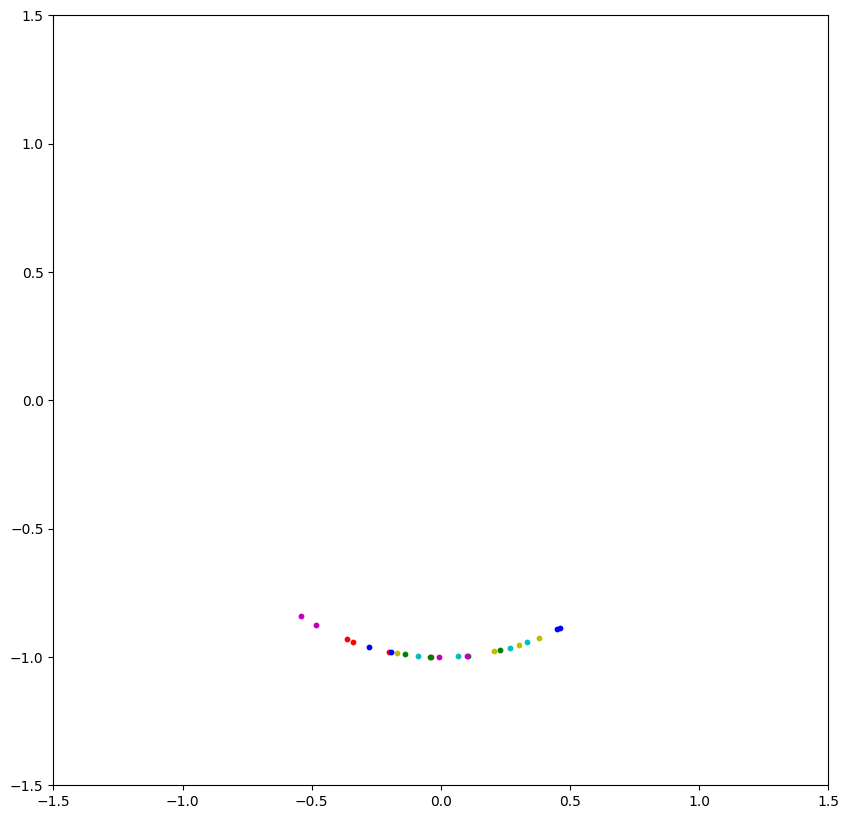

In [768]:
draw(outputs)

In [30]:
import visualization

In [31]:
num_pos = 4
visualization.show2dim(outputs, num_pos)

/home/tianyi/anaconda3/envs/tianyi1.13/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


ValueError: Found array with dim 3. Estimator expected <= 2.

/home/tianyi/anaconda3/envs/tianyi1.13/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/tianyi/anaconda3/envs/tianyi1.13/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


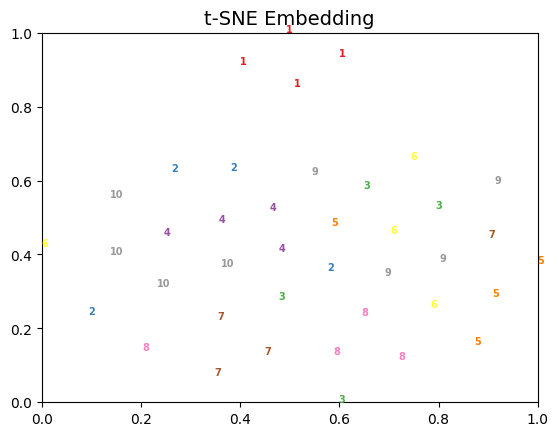

In [84]:
visualization.show2dim(inputs, num_pos)

/home/tianyi/anaconda3/envs/tianyi1.13/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/tianyi/anaconda3/envs/tianyi1.13/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to sp

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

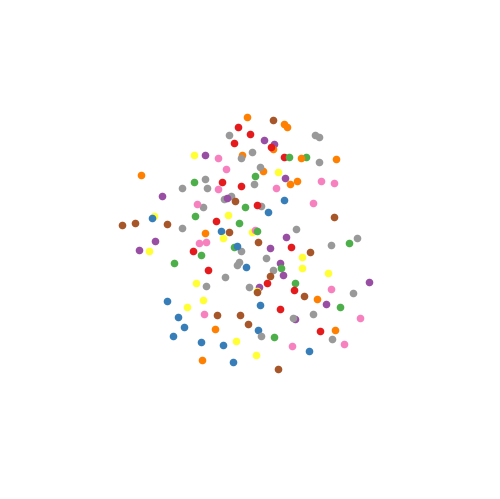

In [59]:
visualization.show3dim(outputs, num_pos)

In [23]:
import extractor as ViT

In [24]:
paths = ['../dataset0/cam0/1/0.jpeg', '../dataset0/cam1/13/60.jpeg']
a = ViT.get_ViT_feat(paths[0])
b = ViT.get_ViT_feat(paths[1])

In [25]:
import torch.nn.functional as tnf
cos_sim = tnf.cosine_similarity(a, b)
cos_sim

tensor([0.8442], device='cuda:0', dtype=torch.float16)

In [120]:
x = torch.Tensor([-0.5, 0.5])
x = nn.functional.normalize(x, dim=0)
x

tensor([-0.7071,  0.7071])

In [121]:
x[0]**2+x[1]**2

tensor(1.0000)